<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/LSTM%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# STEP 1: IMPORT LIBRARIES AND SETUP ENVIRONMENT
# ==============================================================================
import pandas as pd
import numpy as np
import os
import sys
import pickle
import timeit
from tqdm import tqdm

In [ ]:
# Audio Processing
import librosa
import librosa.display

In [ ]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Keras / TensorFlow for Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense,
    LSTM, Reshape
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Ignore warnings for a cleaner output
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Install libsndfile for audio processing in Colab
!apt-get update -qq && apt-get install -y libsndfile1 -qq

print("Libraries imported and system updated successfully.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Libraries imported and system updated successfully.


In [ ]:
# ==============================================================================
# STEP 2: MOUNT GOOGLE DRIVE AND SET PATHS
# ==============================================================================
print("\nStep 2: Mounting Google Drive and setting paths...")

from google.colab import drive
drive.mount('/content/drive')


Step 2: Mounting Google Drive and setting paths...
Mounted at /content/drive


In [ ]:
# !!! IMPORTANT: MAKE SURE THIS PATH IS CORRECT !!!
CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"

if not os.path.exists(CREMA_D_PATH):
    print(f"ERROR: The path '{CREMA_D_PATH}' does not exist.")
    print("Please make sure you have uploaded the 'AudioWAV' folder to your Google Drive and updated the CREMA_D_PATH variable.")
else:
    print("Dataset path confirmed.")

Dataset path confirmed.


In [ ]:
# ==============================================================================
# STEP 3: LOAD AND PROCESS DATASET METADATA (No Changes Here)
# ==============================================================================
print("\nStep 3: Loading and processing CREMA-D metadata...")

crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(os.path.join(CREMA_D_PATH, file))
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

print("CREMA-D DataFrame created successfully.")
print("Emotion Counts:")
print(data_path['Emotions'].value_counts())


Step 3: Loading and processing CREMA-D metadata...
CREMA-D DataFrame created successfully.
Emotion Counts:
Emotions
sad        1271
happy      1271
angry      1271
fear       1271
disgust    1271
neutral    1087
Name: count, dtype: int64



Step 4: Visualizing data distribution...


/tmp/ipython-input-11-753509345.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_path.Emotions, palette="viridis")


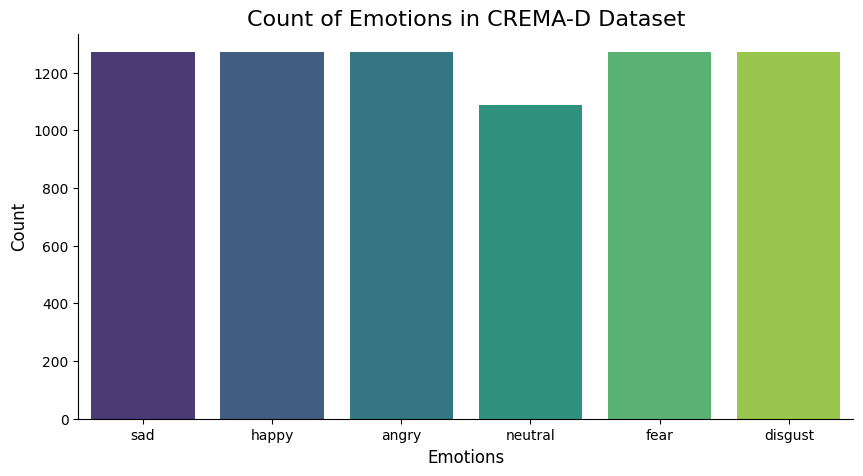

In [ ]:
# ==============================================================================
# STEP 4: VISUALIZING DATA DISTRIBUTION (No Changes Here)
# ==============================================================================
print("\nStep 4: Visualizing data distribution...")

plt.figure(figsize=(10, 5))
plt.title('Count of Emotions in CREMA-D Dataset', size=16)
sns.countplot(x=data_path.Emotions, palette="viridis")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:

# ==============================================================================
# STEP 5: **NEW** FEATURE EXTRACTION & AUGMENTATION FUNCTIONS
# ==============================================================================
print("\nStep 5: Defining NEW feature extraction and augmentation functions...")

# --- Data Augmentation Functions (Added Time Stretching) ---
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


# --- NEW Feature Extraction Function (extracts MFCCs over time) ---
def extract_features_sequential(data, sr=22050, n_mfcc=40):
    """Extracts MFCCs and returns them as a sequence (time_steps, n_mfcc)"""
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T # Transpose to get (time_steps, n_mfcc)

# --- NEW Function to get all features including augmentations ---
def get_features_with_augmentation_sequential(path):
    """
    Loads an audio file and returns a list of feature sequences:
    [original_features, noise_features, pitch_features, stretch_features]
    """
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # 1. Original
    res1 = extract_features_sequential(data, sr)
    # 2. Noise
    noise_data = noise(data)
    res2 = extract_features_sequential(noise_data, sr)
    # 3. Pitch
    pitch_data = pitch(data, sr)
    res3 = extract_features_sequential(pitch_data, sr)
    # 4. Stretch
    stretch_data = stretch(data)
    res4 = extract_features_sequential(stretch_data, sr)

    return [res1, res2, res3, res4]

print("Functions defined.")


Step 5: Defining NEW feature extraction and augmentation functions...
Functions defined.


In [ ]:
# ==============================================================================
# STEP 6: **NEW** GENERATE, PAD, AND SAVE FEATURES (LONG PROCESS)
# ==============================================================================
print("\nStep 6: Generating sequential features from audio files. This may take a long time...")

start_time = timeit.default_timer()

X_seq, Y_seq = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path)):
    try:
        feature_list = get_features_with_augmentation_sequential(path)
        for features in feature_list:
            X_seq.append(features)
            Y_seq.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Find the maximum length of a sequence
max_len = max([len(x) for x in X_seq])
print(f"\nMaximum sequence length: {max_len}")

# Pad all sequences to the maximum length
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', dtype='float32')

stop_time = timeit.default_timer()
print(f'Feature extraction completed in: {stop_time - start_time:.2f}s')

# Save features and labels using numpy for efficiency
np.save('X_padded_features.npy', X_padded)
np.save('Y_labels.npy', np.array(Y_seq))
# Save the max_len value for the prediction script
with open('max_len.txt', 'w') as f:
    f.write(str(max_len))

print("Sequential features saved to 'X_padded_features.npy' and 'Y_labels.npy'")
print("Max sequence length saved to 'max_len.txt'")


Step 6: Generating sequential features from audio files. This may take a long time...


100%|██████████| 7442/7442 [20:45<00:00,  5.98it/s]



Maximum sequence length: 135
Feature extraction completed in: 1245.84s
Sequential features saved to 'X_padded_features.npy' and 'Y_labels.npy'
Max sequence length saved to 'max_len.txt'


In [ ]:
# ==============================================================================
# STEP 7: **NEW** LOAD SAVED FEATURES AND PREPARE FOR MODELING
# ==============================================================================
print("\nStep 7: Loading sequential features and preparing data for the model...")

# Load the saved features and labels
X = np.load('X_padded_features.npy')
Y = np.load('Y_labels.npy')

# One-Hot Encode the labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

# Scale the features
# We need to reshape data to 2D for scaler, then reshape back to 3D for model
scaler = StandardScaler()
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_train_scaled_2d = scaler.fit_transform(x_train_2d)
x_train = x_train_scaled_2d.reshape(x_train.shape)

x_test_2d = x_test.reshape(x_test.shape[0], -1)
x_test_scaled_2d = scaler.transform(x_test_2d)
x_test = x_test_scaled_2d.reshape(x_test.shape)

print(f"Data shapes: \nx_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")


Step 7: Loading sequential features and preparing data for the model...
Data shapes: 
x_train: (23814, 135, 40)
y_train: (23814, 6)
x_test: (5954, 135, 40)
y_test: (5954, 6)


In [ ]:
# ==============================================================================
# STEP 8: **NEW** BUILD THE HYBRID CNN-LSTM MODEL
# ==============================================================================
print("\nStep 8: Building the Hybrid CNN-LSTM model...")

# Input shape will be (max_len, n_mfcc)
input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential()

# 1st CNN Layer
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# 2nd CNN Layer
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

# 3rd CNN Layer
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# LSTM Layer
model.add(LSTM(64))
model.add(Dropout(0.3))

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Step 8: Building the Hybrid CNN-LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 135, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 135, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 68, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 68, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 34, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,686 (1.07 MB)

 Trainable params: 278,662 (1.06 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [18]:
# ==============================================================================
# STEP 9: TRAIN THE MODEL (No changes here, just runs on new data/model)
# ==============================================================================
print("\nStep 9: Training the model...")

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_cnn_lstm_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100, # EarlyStopping will find the best epoch
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)


Step 9: Training the model...
Epoch 1/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.2879 - loss: 1.7876

373/373 ━━━━━━━━━━━━━━━━━━━━ 127s 323ms/step - accuracy: 0.2882 - loss: 1.7867 - val_accuracy: 0.4449 - val_loss: 1.3944 - learning_rate: 0.0010
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.4442 - loss: 1.3997

373/373 ━━━━━━━━━━━━━━━━━━━━ 139s 317ms/step - accuracy: 0.4442 - loss: 1.3996 - val_accuracy: 0.5099 - val_loss: 1.2511 - learning_rate: 0.0010
Epoch 3/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5162 - loss: 1.2507

373/373 ━━━━━━━━━━━━━━━━━━━━ 144s 322ms/step - accuracy: 0.5163 - loss: 1.2506 - val_accuracy: 0.5507 - val_loss: 1.1500 - learning_rate: 0.0010
Epoch 4/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5690 - loss: 1.1428

373/373 ━━━━━━━━━━━━━━━━━━━━ 146s 333ms/step - accuracy: 0.5690 - loss: 1.1427 - val_accuracy: 0.5663 - val_loss: 1.1093 - learning_rate: 0.0010
Epoch 5/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6159 - loss: 1.0423

373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 323ms/step - accuracy: 0.6160 - loss: 1.0422 - val_accuracy: 0.6083 - val_loss: 1.0191 - learning_rate: 0.0010
Epoch 6/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6564 - loss: 0.9351

373/373 ━━━━━━━━━━━━━━━━━━━━ 118s 316ms/step - accuracy: 0.6564 - loss: 0.9351 - val_accuracy: 0.6407 - val_loss: 0.9524 - learning_rate: 0.0010
Epoch 7/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6716 - loss: 0.8986

373/373 ━━━━━━━━━━━━━━━━━━━━ 145s 325ms/step - accuracy: 0.6717 - loss: 0.8985 - val_accuracy: 0.6611 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 8/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7192 - loss: 0.7813

373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 326ms/step - accuracy: 0.7192 - loss: 0.7813 - val_accuracy: 0.6693 - val_loss: 0.9058 - learning_rate: 0.0010
Epoch 9/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7467 - loss: 0.7151

373/373 ━━━━━━━━━━━━━━━━━━━━ 122s 326ms/step - accuracy: 0.7467 - loss: 0.7151 - val_accuracy: 0.6723 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 10/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7471 - loss: 0.7100

373/373 ━━━━━━━━━━━━━━━━━━━━ 122s 326ms/step - accuracy: 0.7472 - loss: 0.7098 - val_accuracy: 0.7366 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 11/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 139s 319ms/step - accuracy: 0.7843 - loss: 0.6028 - val_accuracy: 0.6863 - val_loss: 0.8659 - learning_rate: 0.0010
Epoch 12/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7868 - loss: 0.6021

373/373 ━━━━━━━━━━━━━━━━━━━━ 117s 313ms/step - accuracy: 0.7869 - loss: 0.6019 - val_accuracy: 0.7501 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 13/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8230 - loss: 0.4997

373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 303ms/step - accuracy: 0.8230 - loss: 0.4998 - val_accuracy: 0.7659 - val_loss: 0.6597 - learning_rate: 0.0010
Epoch 14/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 114s 305ms/step - accuracy: 0.8377 - loss: 0.4701 - val_accuracy: 0.7474 - val_loss: 0.7480 - learning_rate: 0.0010
Epoch 15/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8501 - loss: 0.4336

373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 308ms/step - accuracy: 0.8501 - loss: 0.4336 - val_accuracy: 0.7855 - val_loss: 0.6389 - learning_rate: 0.0010
Epoch 16/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 309ms/step - accuracy: 0.8572 - loss: 0.3990 - val_accuracy: 0.7800 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 17/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 321ms/step - accuracy: 0.8621 - loss: 0.3902 - val_accuracy: 0.7751 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 18/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - accuracy: 0.8789 - loss: 0.3469 - val_accuracy: 0.7603 - val_loss: 0.7482 - learning_rate: 0.0010
Epoch 19/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8908 - loss: 0.3140

373/373 ━━━━━━━━━━━━━━━━━━━━ 144s 328ms/step - accuracy: 0.8908 - loss: 0.3140 - val_accuracy: 0.8109 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 20/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 323ms/step - accuracy: 0.8919 - loss: 0.3215 - val_accuracy: 0.7859 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 21/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 139s 315ms/step - accuracy: 0.9020 - loss: 0.2898 - val_accuracy: 0.7944 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 22/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 136s 299ms/step - accuracy: 0.9044 - loss: 0.2869 - val_accuracy: 0.8027 - val_loss: 0.6196 - learning_rate: 0.0010
Epoch 23/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9092 - loss: 0.2671

373/373 ━━━━━━━━━━━━━━━━━━━━ 113s 304ms/step - accuracy: 0.9092 - loss: 0.2671 - val_accuracy: 0.8146 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 24/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9126 - loss: 0.2576

373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 320ms/step - accuracy: 0.9126 - loss: 0.2576 - val_accuracy: 0.8198 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 25/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 140s 316ms/step - accuracy: 0.9225 - loss: 0.2313 - val_accuracy: 0.8085 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 26/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accuracy: 0.9238 - loss: 0.2305 - val_accuracy: 0.7936 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 27/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 313ms/step - accuracy: 0.9281 - loss: 0.2105 - val_accuracy: 0.7941 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 28/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9097 - loss: 0.2579

373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 310ms/step - accuracy: 0.9098 - loss: 0.2577 - val_accuracy: 0.8230 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 29/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 312ms/step - accuracy: 0.9354 - loss: 0.1915 - val_accuracy: 0.8030 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 30/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9222 - loss: 0.2331

373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 313ms/step - accuracy: 0.9222 - loss: 0.2330 - val_accuracy: 0.8331 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 31/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9167 - loss: 0.2553

373/373 ━━━━━━━━━━━━━━━━━━━━ 137s 300ms/step - accuracy: 0.9168 - loss: 0.2552 - val_accuracy: 0.8352 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 32/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9396 - loss: 0.1797

373/373 ━━━━━━━━━━━━━━━━━━━━ 115s 308ms/step - accuracy: 0.9396 - loss: 0.1797 - val_accuracy: 0.8364 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 33/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 304ms/step - accuracy: 0.9461 - loss: 0.1572 - val_accuracy: 0.8317 - val_loss: 0.5760 - learning_rate: 0.0010
Epoch 34/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9172 - loss: 0.2403

373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 320ms/step - accuracy: 0.9172 - loss: 0.2401 - val_accuracy: 0.8482 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 35/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 322ms/step - accuracy: 0.9452 - loss: 0.1609 - val_accuracy: 0.8357 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 36/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 311ms/step - accuracy: 0.9471 - loss: 0.1557 - val_accuracy: 0.8445 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 37/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 311ms/step - accuracy: 0.9448 - loss: 0.1712 - val_accuracy: 0.8294 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 38/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9483 - loss: 0.1591

373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 312ms/step - accuracy: 0.9483 - loss: 0.1590 - val_accuracy: 0.8493 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 39/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 300ms/step - accuracy: 0.9517 - loss: 0.1412 - val_accuracy: 0.8295 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 40/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 117s 313ms/step - accuracy: 0.9511 - loss: 0.1491 - val_accuracy: 0.8309 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 41/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - accuracy: 0.9457 - loss: 0.1603 - val_accuracy: 0.8465 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 42/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9527 - loss: 0.1473

373/373 ━━━━━━━━━━━━━━━━━━━━ 119s 319ms/step - accuracy: 0.9527 - loss: 0.1473 - val_accuracy: 0.8524 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 43/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 316ms/step - accuracy: 0.9499 - loss: 0.1465 - val_accuracy: 0.8433 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 44/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9569 - loss: 0.1305

373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 313ms/step - accuracy: 0.9569 - loss: 0.1305 - val_accuracy: 0.8624 - val_loss: 0.4683 - learning_rate: 0.0010
Epoch 45/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 140s 308ms/step - accuracy: 0.9536 - loss: 0.1457 - val_accuracy: 0.8453 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 46/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 144s 315ms/step - accuracy: 0.9498 - loss: 0.1532 - val_accuracy: 0.8576 - val_loss: 0.5189 - learning_rate: 0.0010
Epoch 47/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 121s 324ms/step - accuracy: 0.9607 - loss: 0.1224 - val_accuracy: 0.8483 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 48/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 119s 319ms/step - accuracy: 0.9639 - loss: 0.1134 - val_accuracy: 0.8413 - val_loss: 0.6138 - learning_rate: 0.0010
Epoch 49/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9300 - loss: 0.2109

373/373 ━━━━━━━━━━━━━━━━━━━━ 140s 315ms/step - accuracy: 0.9301 - loss: 0.2108 - val_accuracy: 0.8658 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 50/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 119s 318ms/step - accuracy: 0.9595 - loss: 0.1267 - val_accuracy: 0.8547 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 51/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 337ms/step - accuracy: 0.9638 - loss: 0.1098 - val_accuracy: 0.8636 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 52/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9661 - loss: 0.1020

373/373 ━━━━━━━━━━━━━━━━━━━━ 135s 318ms/step - accuracy: 0.9661 - loss: 0.1020 - val_accuracy: 0.8661 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 53/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 146s 329ms/step - accuracy: 0.9523 - loss: 0.1387 - val_accuracy: 0.8603 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 54/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 117s 314ms/step - accuracy: 0.9684 - loss: 0.0969 - val_accuracy: 0.8609 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 55/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 311ms/step - accuracy: 0.9618 - loss: 0.1245 - val_accuracy: 0.8603 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 56/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 122s 327ms/step - accuracy: 0.9660 - loss: 0.1035 - val_accuracy: 0.8462 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 57/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9704 - loss: 0.0883
Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
373/373 ━━━━━━━━━━━━━━━━━━━━ 136s 312ms/step - accuracy:

373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 309ms/step - accuracy: 0.9767 - loss: 0.0694 - val_accuracy: 0.8796 - val_loss: 0.4710 - learning_rate: 5.0000e-04
Epoch 59/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 300ms/step - accuracy: 0.9864 - loss: 0.0423 - val_accuracy: 0.8762 - val_loss: 0.5131 - learning_rate: 5.0000e-04
Epoch 60/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 301ms/step - accuracy: 0.9854 - loss: 0.0512 - val_accuracy: 0.8786 - val_loss: 0.4985 - learning_rate: 5.0000e-04
Epoch 61/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 145s 309ms/step - accuracy: 0.9768 - loss: 0.0679 - val_accuracy: 0.8742 - val_loss: 0.5262 - learning_rate: 5.0000e-04
Epoch 62/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 328ms/step - accuracy: 0.9856 - loss: 0.0468 - val_accuracy: 0.8740 - val_loss: 0.5226 - learning_rate: 5.0000e-04
Epoch 63/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9871 - loss: 0.0449

373/373 ━━━━━━━━━━━━━━━━━━━━ 136s 311ms/step - accuracy: 0.9871 - loss: 0.0449 - val_accuracy: 0.8828 - val_loss: 0.4730 - learning_rate: 5.0000e-04
Epoch 64/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 145s 319ms/step - accuracy: 0.9841 - loss: 0.0511 - val_accuracy: 0.8752 - val_loss: 0.5351 - learning_rate: 5.0000e-04
Epoch 65/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9806 - loss: 0.0600

373/373 ━━━━━━━━━━━━━━━━━━━━ 118s 316ms/step - accuracy: 0.9806 - loss: 0.0599 - val_accuracy: 0.8850 - val_loss: 0.4877 - learning_rate: 5.0000e-04
Epoch 66/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 140s 310ms/step - accuracy: 0.9846 - loss: 0.0482 - val_accuracy: 0.8829 - val_loss: 0.4908 - learning_rate: 5.0000e-04
Epoch 67/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9848 - loss: 0.0483

373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 310ms/step - accuracy: 0.9848 - loss: 0.0483 - val_accuracy: 0.8905 - val_loss: 0.4567 - learning_rate: 5.0000e-04
Epoch 68/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 312ms/step - accuracy: 0.9882 - loss: 0.0370 - val_accuracy: 0.8688 - val_loss: 0.5940 - learning_rate: 5.0000e-04
Epoch 69/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 145s 321ms/step - accuracy: 0.9834 - loss: 0.0509 - val_accuracy: 0.8774 - val_loss: 0.5208 - learning_rate: 5.0000e-04
Epoch 70/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 115s 307ms/step - accuracy: 0.9873 - loss: 0.0406 - val_accuracy: 0.8804 - val_loss: 0.5068 - learning_rate: 5.0000e-04
Epoch 71/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 306ms/step - accuracy: 0.9856 - loss: 0.0432 - val_accuracy: 0.8863 - val_loss: 0.4820 - learning_rate: 5.0000e-04
Epoch 72/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9855 - loss: 0.0445

373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 320ms/step - accuracy: 0.9855 - loss: 0.0445 - val_accuracy: 0.8912 - val_loss: 0.4676 - learning_rate: 5.0000e-04
Epoch 73/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9873 - loss: 0.0378

373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 323ms/step - accuracy: 0.9873 - loss: 0.0378 - val_accuracy: 0.8913 - val_loss: 0.4632 - learning_rate: 5.0000e-04
Epoch 74/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - accuracy: 0.9889 - loss: 0.0366 - val_accuracy: 0.8796 - val_loss: 0.5150 - learning_rate: 5.0000e-04
Epoch 75/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 320ms/step - accuracy: 0.9838 - loss: 0.0489 - val_accuracy: 0.8846 - val_loss: 0.4915 - learning_rate: 5.0000e-04
Epoch 76/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 317ms/step - accuracy: 0.9877 - loss: 0.0397 - val_accuracy: 0.8797 - val_loss: 0.5367 - learning_rate: 5.0000e-04
Epoch 77/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accuracy: 0.9865 - loss: 0.0425 - val_accuracy: 0.8870 - val_loss: 0.4841 - learning_rate: 5.0000e-04
Epoch 78/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9816 - loss: 0.0606
Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 31

373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 328ms/step - accuracy: 0.9894 - loss: 0.0318 - val_accuracy: 0.8917 - val_loss: 0.4632 - learning_rate: 2.5000e-04
Epoch 80/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9923 - loss: 0.0234

373/373 ━━━━━━━━━━━━━━━━━━━━ 122s 328ms/step - accuracy: 0.9923 - loss: 0.0234 - val_accuracy: 0.8923 - val_loss: 0.4797 - learning_rate: 2.5000e-04
Epoch 81/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 311ms/step - accuracy: 0.9883 - loss: 0.0386 - val_accuracy: 0.8920 - val_loss: 0.4800 - learning_rate: 2.5000e-04
Epoch 82/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9929 - loss: 0.0210

373/373 ━━━━━━━━━━━━━━━━━━━━ 154s 344ms/step - accuracy: 0.9929 - loss: 0.0210 - val_accuracy: 0.8933 - val_loss: 0.4817 - learning_rate: 2.5000e-04
Epoch 83/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9935 - loss: 0.0189

373/373 ━━━━━━━━━━━━━━━━━━━━ 129s 309ms/step - accuracy: 0.9935 - loss: 0.0189 - val_accuracy: 0.8957 - val_loss: 0.4682 - learning_rate: 2.5000e-04
Epoch 84/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9943 - loss: 0.0176

373/373 ━━━━━━━━━━━━━━━━━━━━ 150s 332ms/step - accuracy: 0.9943 - loss: 0.0176 - val_accuracy: 0.8984 - val_loss: 0.4934 - learning_rate: 2.5000e-04
Epoch 85/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9949 - loss: 0.0147

373/373 ━━━━━━━━━━━━━━━━━━━━ 137s 318ms/step - accuracy: 0.9949 - loss: 0.0147 - val_accuracy: 0.9002 - val_loss: 0.4883 - learning_rate: 2.5000e-04
Epoch 86/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 320ms/step - accuracy: 0.9953 - loss: 0.0157 - val_accuracy: 0.8933 - val_loss: 0.5324 - learning_rate: 2.5000e-04
Epoch 87/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 324ms/step - accuracy: 0.9947 - loss: 0.0185 - val_accuracy: 0.8984 - val_loss: 0.5000 - learning_rate: 2.5000e-04
Epoch 88/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 144s 329ms/step - accuracy: 0.9914 - loss: 0.0287 - val_accuracy: 0.8954 - val_loss: 0.5074 - learning_rate: 2.5000e-04
Epoch 89/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 140s 324ms/step - accuracy: 0.9936 - loss: 0.0209 - val_accuracy: 0.8940 - val_loss: 0.5090 - learning_rate: 2.5000e-04
Epoch 90/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9945 - loss: 0.0166
Epoch 90: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 32

373/373 ━━━━━━━━━━━━━━━━━━━━ 127s 341ms/step - accuracy: 0.9956 - loss: 0.0153 - val_accuracy: 0.9016 - val_loss: 0.4755 - learning_rate: 1.2500e-04
Epoch 92/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 136s 324ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9009 - val_loss: 0.4889 - learning_rate: 1.2500e-04
Epoch 93/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - accuracy: 0.9947 - loss: 0.0154 - val_accuracy: 0.9009 - val_loss: 0.4804 - learning_rate: 1.2500e-04
Epoch 94/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9011 - val_loss: 0.4907 - learning_rate: 1.2500e-04
Epoch 95/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9965 - loss: 0.0113

373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 321ms/step - accuracy: 0.9965 - loss: 0.0113 - val_accuracy: 0.9058 - val_loss: 0.4701 - learning_rate: 1.2500e-04
Epoch 96/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 116s 310ms/step - accuracy: 0.9962 - loss: 0.0102 - val_accuracy: 0.9019 - val_loss: 0.4981 - learning_rate: 1.2500e-04
Epoch 97/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 141s 308ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 0.9031 - val_loss: 0.4914 - learning_rate: 1.2500e-04
Epoch 98/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 151s 332ms/step - accuracy: 0.9959 - loss: 0.0115 - val_accuracy: 0.9053 - val_loss: 0.4825 - learning_rate: 1.2500e-04
Epoch 99/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 120s 321ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9034 - val_loss: 0.5015 - learning_rate: 1.2500e-04
Epoch 100/100
372/373 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9950 - loss: 0.0178
Epoch 100: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 3


Step 10: Evaluating the model performance...


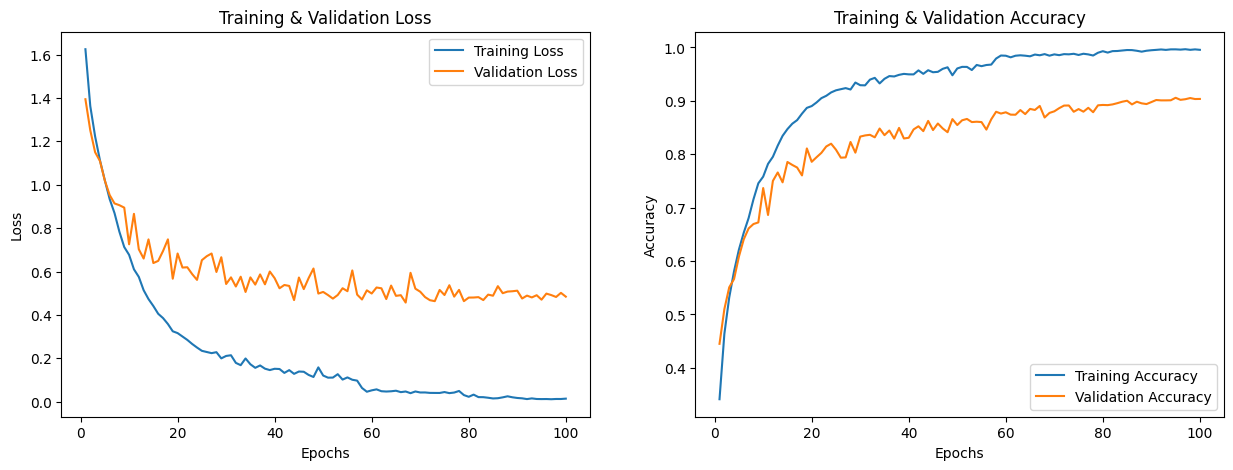


Final Model Evaluation on Test Data:
Test Accuracy: 90.58%
Test Loss: 0.4701
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.95      0.93      0.94      1037
     disgust       0.91      0.88      0.90       979
        fear       0.90      0.89      0.90      1027
       happy       0.92      0.89      0.90      1035
     neutral       0.88      0.93      0.90       857
         sad       0.87      0.92      0.89      1019

    accuracy                           0.91      5954
   macro avg       0.91      0.91      0.91      5954
weighted avg       0.91      0.91      0.91      5954



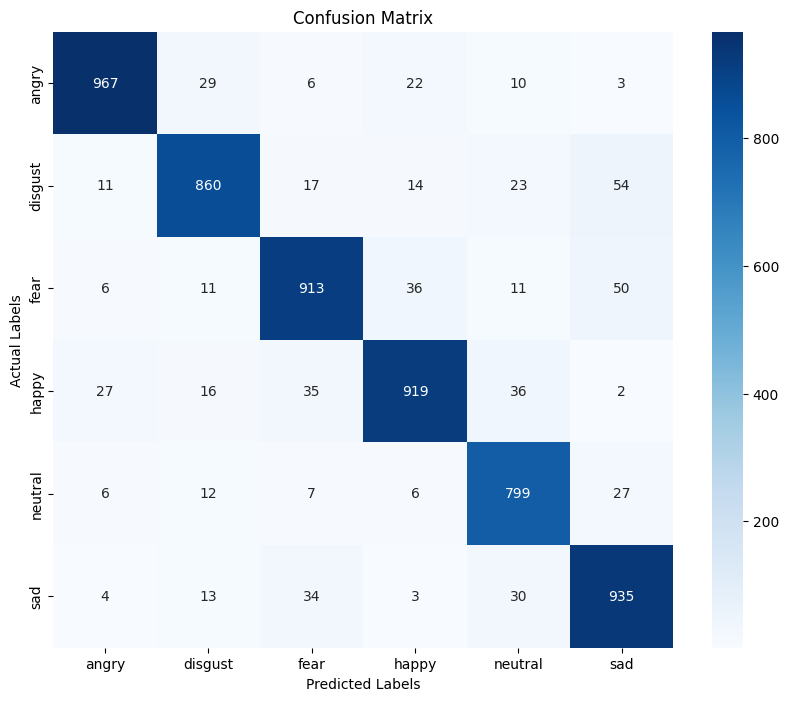


--- Example Predictions with Emotional Valence ---
Actual: sad        | Predicted: neutral    | Valence: Neutral
Actual: neutral    | Predicted: neutral    | Valence: Neutral
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: disgust    | Predicted: disgust    | Valence: Negative
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: neutral    | Predicted: neutral    | Valence: Neutral
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: fear       | Predicted: fear       | Valence: Negative
Actual: happy      | Predicted: happy      | Valence: Positive


In [19]:
# ==============================================================================
# STEP 10: EVALUATE THE MODEL & **ADD EMOTIONAL VALENCE**
# ==============================================================================
print("\nStep 10: Evaluating the model performance...")

# Plot training history
epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epochs, history.history['loss'], label='Training Loss'); ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss'); ax[0].set_xlabel('Epochs'); ax[0].set_ylabel('Loss'); ax[0].legend()
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy'); ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy'); ax[1].set_xlabel('Epochs'); ax[1].set_ylabel('Accuracy'); ax[1].legend()
plt.show()

# Final evaluation
print("\nFinal Model Evaluation on Test Data:")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions, Confusion Matrix, and Classification Report
y_pred = model.predict(x_test)
y_pred_labels = encoder.inverse_transform(y_pred)
y_test_labels = encoder.inverse_transform(y_test)
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix'); plt.ylabel('Actual Labels'); plt.xlabel('Predicted Labels'); plt.show()

# --- NEW: Emotional Valence Mapping ---
def get_valence(emotion):
    emotion = emotion.lower()
    if emotion == 'happy':
        return 'Positive'
    elif emotion in ['sad', 'angry', 'fear', 'disgust']:
        return 'Negative'
    else: # neutral
        return 'Neutral'

# Show some examples with valence
print("\n--- Example Predictions with Emotional Valence ---")
for i in range(10):
    actual_emotion = y_test_labels[i][0]
    predicted_emotion = y_pred_labels[i][0]
    valence = get_valence(predicted_emotion)
    print(f"Actual: {actual_emotion:<10} | Predicted: {predicted_emotion:<10} | Valence: {valence}")

In [20]:
# ==============================================================================
# STEP 11: SAVE MODEL, SCALER, AND ENCODER (Updated filenames)
# ==============================================================================
print("\nStep 11: Saving model architecture, weights, and preprocessing objects...")

model_json = model.to_json()
with open("cnn_lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# Best weights already saved as 'best_cnn_lstm_model.h5'
print("Model architecture saved to cnn_lstm_model.json")
print("Best model weights saved to best_cnn_lstm_model.h5")

with open('scaler_seq.pickle', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder_seq.pickle', 'wb') as f:
    pickle.dump(encoder, f)
print("Scaler saved to scaler_seq.pickle")
print("Encoder saved to encoder_seq.pickle")


Step 11: Saving model architecture, weights, and preprocessing objects...
Model architecture saved to cnn_lstm_model.json
Best model weights saved to best_cnn_lstm_model.h5
Scaler saved to scaler_seq.pickle
Encoder saved to encoder_seq.pickle


In [21]:
# ==============================================================================
# STEP 12: **UPDATED** PREDICTION SCRIPT FOR NEW AUDIO
# ==============================================================================
print("\nStep 12: Example prediction script for a new audio file.")
print("You can use this block to test single audio files in the future.")

# Define the prediction function
def predict_emotion_and_valence(audio_path):
    # --- Load all necessary files ---
    with open('cnn_lstm_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("best_cnn_lstm_model.h5")

    with open('scaler_seq.pickle', 'rb') as f:
        scaler = pickle.load(f)
    with open('encoder_seq.pickle', 'rb') as f:
        encoder = pickle.load(f)
    with open('max_len.txt', 'r') as f:
        max_len = int(f.read())

    # --- Feature Extraction for a single file ---
    data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
    features = extract_features_sequential(data, sr, n_mfcc=40)

    # --- Padding, Scaling and Reshaping ---
    padded_features = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
    padded_features_2d = padded_features.reshape(1, -1)
    scaled_features_2d = scaler.transform(padded_features_2d)
    final_features = scaled_features_2d.reshape(padded_features.shape)

    # --- Prediction ---
    prediction = loaded_model.predict(final_features, verbose=0)
    predicted_label = encoder.inverse_transform(prediction)[0][0]
    predicted_valence = get_valence(predicted_label)

    return predicted_label, predicted_valence

# --- USAGE EXAMPLE ---
try:
    test_file_path = data_path.Path.sample(1).iloc[0]
    predicted_emotion, predicted_valence = predict_emotion_and_valence(test_file_path)

    print(f"\n--- Prediction Test ---")
    print(f"File Path: {test_file_path}")
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print(f"Predicted Valence: {predicted_valence.upper()}")
except Exception as e:
    print(f"\nCould not run prediction example. Error: {e}")


Step 12: Example prediction script for a new audio file.
You can use this block to test single audio files in the future.

--- Prediction Test ---
File Path: /content/drive/MyDrive/AudioWAV/1067_WSI_NEU_XX.wav
Predicted Emotion: NEUTRAL
Predicted Valence: NEUTRAL


In [ ]:
# ==============================================================================
# FINAL AI EMOTION COMPANION (V5) - Continuous, Intelligent & Mic-Enabled
# ==============================================================================
import os
import io
import random
import pickle
import numpy as np
import librosa
from IPython.display import display, HTML, Markdown, clear_output

# --- NECESSARY IMPORTS ---
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- CONFIGURATION ---
MODEL_JSON_PATH = "cnn_lstm_model.json"
MODEL_WEIGHTS_PATH = "best_cnn_lstm_model.h5"
SCALER_PATH = "scaler_seq.pickle"
ENCODER_PATH = "encoder_seq.pickle"
MAX_LEN_PATH = "max_len.txt"
RECORDING_FILENAME = "user_audio.wav"

# --- UPGRADED JAVASCRIPT FOR A BETTER MIC RECORDER ---
AUDIO_HTML_WITH_TIMER = """
<script>
var record = () => new Promise(async resolve => {
  const div = document.createElement('div');
  const startButton = document.createElement('button');
  startButton.textContent = 'Start Recording';
  div.appendChild(startButton);

  const stopButton = document.createElement('button');
  stopButton.textContent = 'Stop Recording';
  stopButton.disabled = true;
  div.appendChild(stopButton);

  const statusDiv = document.createElement('div');
  statusDiv.innerHTML = '<i>Ready to record.</i>';
  div.appendChild(statusDiv);

  const audio = document.createElement('audio');
  audio.controls = true;
  div.appendChild(audio);

  document.body.appendChild(div);

  let recorder, stream, timerInterval;
  let seconds = 0;

  startButton.onclick = async () => {
    try {
      stream = await navigator.mediaDevices.getUserMedia({audio: true});
      recorder = new MediaRecorder(stream);
      let chunks = [];
      recorder.ondataavailable = e => chunks.push(e.data);

      recorder.onstop = e => {
        const blob = new Blob(chunks, { 'type' : 'audio/ogg; codecs=opus' });
        const audioURL = window.URL.createObjectURL(blob);
        audio.src = audioURL;
        const reader = new FileReader();
        reader.readAsDataURL(blob);
        reader.onloadend = () => {
            statusDiv.innerHTML = '<i>Recording finished. Click play to listen.</i>';
            resolve(reader.result);
        };
      };

      recorder.start();
      startButton.disabled = true;
      stopButton.disabled = false;
      seconds = 0;
      statusDiv.innerHTML = '🔴 Recording... <b>0s</b>';
      timerInterval = setInterval(() => {
        seconds++;
        statusDiv.innerHTML = `🔴 Recording... <b>${seconds}s</b>`;
      }, 1000);

    } catch (err) {
        statusDiv.innerHTML = `⚠️ Error: Could not access microphone. Please allow permissions.`;
        resolve(null);
    }
  };

  stopButton.onclick = () => {
    recorder.stop();
    stream.getTracks().forEach(track => track.stop());
    clearInterval(timerInterval);
    startButton.disabled = false;
    stopButton.disabled = true;
    statusDiv.innerHTML = '<i>Processing recording...</i>';
  };
});
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML_WITH_TIMER))
  data = eval_js("record()")
  if not data or ',' not in data: return None
  binary = b64decode(data.split(',')[1])
  with open(RECORDING_FILENAME, 'wb') as f: f.write(binary)
  return RECORDING_FILENAME

# --- HELPER FUNCTIONS ---
def extract_features_sequential(data, sr=22050, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

def get_valence(emotion):
    emotion = emotion.lower()
    if emotion == 'happy': return 'Positive'
    elif emotion in ['sad', 'angry', 'fear', 'disgust']: return 'Negative'
    else: return 'Neutral'

# --- RICH RESPONSE GENERATION ---
def get_rich_response(emotion):
    emotion = emotion.lower()
    happy_responses = ["It's wonderful to hear such joy in your voice! Keep that fantastic energy going. 🎉<br>Quote: *'The purpose of our lives is to be happy.'* - Dalai Lama","You sound genuinely happy, and that's amazing! Let's celebrate that feeling. 😊<br>Quote: *'Happiness is not something ready made. It comes from your own actions.'* - Dalai Lama"]
    sad_responses = ["I hear a note of sadness in your voice. Please remember that it's okay to feel this way, and this feeling will pass. Be gentle with yourself.<br>Words of Encouragement: *'The oak fought the wind and was broken, the willow bent when it must and survived.'* - Robert Jordan","It sounds like you're going through a tough time. Remember that every storm runs out of rain. You are stronger than you know.<br>Words of Encouragement: *'A smooth sea never made a skilled sailor.'*"]
    angry_responses = ["There's a strong, intense energy in your voice. When you feel anger, it's a sign that something needs attention. Take a moment for a deep breath.<br>Suggestion: Try the 4-7-8 breathing technique: Inhale for 4 seconds, hold for 7, and exhale slowly for 8. It can make a world of difference.","I sense some anger in your tone. It's a powerful emotion. Before you act, try to channel that energy. Step away from the situation for a few minutes if you can. A clear head makes for better decisions."]
    fear_responses = ["I detect a note of fear. Fear can be paralyzing, but you are capable of moving through it. You are safe in this moment.<br>Suggestion: Distract your mind with something calming. How about a relaxing game like [2048](https://play2048.co/) or listen to this calming song: [Weightless by Marconi Union](https://www.youtube.com/watch?v=UfcAVejslrU).","Your voice suggests you might be feeling fearful. Remember to ground yourself in the present. Focus on one thing you can see, one thing you can hear, and one thing you can feel.<br>Suggestion: Sometimes a happy, upbeat song can change everything. Try listening to this one: [Don't Stop Me Now by Queen](https://www.youtube.com/watch?v=HgzGwKwLmgM)."]
    disgust_responses = ["That's a very strong, negative reaction. Whatever caused it, let's try to reset your mind.<br>Suggestion: Think of three things you are grateful for right now, no matter how small. This can help shift your focus to something positive.","I hear disgust in your voice. Let's not let that feeling linger. <br>Suggestion: Close your eyes and imagine a place where you feel completely at peace, like a quiet beach or a forest. Spend 30 seconds there."]
    neutral_responses = ["Your tone is calm and measured. It's a good state for reflection. What's on your mind today?","I'm picking up a neutral tone. A blank canvas. What would you like to paint on it today?"]
    response_map = {'happy': happy_responses,'sad': sad_responses,'angry': angry_responses,'fear': fear_responses,'disgust': disgust_responses,'neutral': neutral_responses}
    return random.choice(response_map.get(emotion, ["I'm listening. Tell me more."]))

# --- THE MAIN CONTINUOUS COMPANION FUNCTION ---
def run_emotion_companion_continuous():
    # Load models and preprocessors once at the start
    try:
        with open(MODEL_JSON_PATH, 'r') as json_file:
            loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights(MODEL_WEIGHTS_PATH)
        with open(SCALER_PATH, 'rb') as f:
            scaler = pickle.load(f)
        with open(ENCODER_PATH, 'rb') as f:
            encoder = pickle.load(f)
        with open(MAX_LEN_PATH, 'r') as f:
            max_len = int(f.read())
    except Exception as e:
        display(Markdown(f"❌ **Error:** Could not load model files. Please run the training script first. Details: `{e}`"))
        return

    # NEW: More intelligent and welcoming intro
    display(Markdown("## Ready to Listen"))
    display(Markdown("Let's explore the emotion in your voice. I'm here to listen and reflect with you."))
    display(Markdown("> **This is a continuous session. To stop, click the square 'Stop' button next to the cell.**"))

    # NEW: Main conversation loop
    try:
        while True:
            display(HTML("<hr style='border-top: 2px solid #bbb;'>")) # Visual separator
            display(Markdown("### Whenever you're ready, record your voice:"))
            audio_file = get_audio()

            # If user cancels or mic fails, loop again for another try
            if audio_file is None:
                clear_output(wait=True)
                display(Markdown("## Ready to Listen"))
                display(Markdown("Let's explore the emotion in your voice. I'm here to listen and reflect with you."))
                display(Markdown("> **Recording cancelled. Let's try again.**"))
                continue

            # Clear the recorder and show processing steps
            clear_output(wait=True)
            display(Markdown("### 🔍 Listening closely..."))

            # Process audio and predict
            data, sr = librosa.load(audio_file, sr=22050)
            features = extract_features_sequential(data, sr, n_mfcc=40)
            padded_features = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
            padded_features_2d = padded_features.reshape(1, -1)
            scaled_features_2d = scaler.transform(padded_features_2d)
            final_features = scaled_features_2d.reshape(padded_features.shape)

            prediction = model.predict(final_features, verbose=0)
            predicted_label = encoder.inverse_transform(prediction)[0][0]
            predicted_valence = get_valence(predicted_label)

            # Display results with the new persona
            clear_output(wait=True)
            display(Markdown("### 🤔 Here's what I heard..."))
            display(Markdown(f"**Emotion:** **{predicted_label.upper()}**"))
            display(Markdown(f"**Valence:** **{predicted_valence.upper()}**"))

            display(Markdown("### ❤️ A Thought for You..."))
            response = get_rich_response(predicted_label)
            display(Markdown(response))

    except KeyboardInterrupt:
        # Handle the user stopping the cell gracefully
        clear_output(wait=True)
        display(Markdown("### Session Ended. \nHope this was helpful. Have a great day!"))

# --- START THE CONTINUOUS SESSION ---
run_emotion_companion_continuous()

### 🤔 Here's what I heard...

**Emotion:** **ANGRY**

**Valence:** **NEGATIVE**

### ❤️ A Thought for You...

I sense some anger in your tone. It's a powerful emotion. Before you act, try to channel that energy. Step away from the situation for a few minutes if you can. A clear head makes for better decisions.

### Whenever you're ready, record your voice: